# Time Series - Stock Price Prediction
## Part 2 - Data Preprocessing
This notebook focuses on processing the filtered dataset containing the historical prices of Stock over the past five years.

Preprocessed and transformed data divided into training, validation, and testing subsets, stored in an interim location for the training phase.

### 1. INITIALIZATION

In [ ]:
# Import necessary libraries and modules
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import joblib
import matplotlib.dates as mdates

In [ ]:
# Set output width
pd.set_option("display.width", 120)

### 2. LOADING DATASET

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:

data_file_location = "/content/drive/MyDrive/Colab_Notebooks/"
data_file_name = "AshokLeyland_stock_price_recent.csv"

# Load file from Google Drive
data = pd.read_csv(data_file_location + data_file_name)
print(data.tail())

            Date   Adj_Close       Close        High         Low        Open   Volume        20MA        50MA  \
1233  2025-04-16  214.399994  214.399994  215.500000  212.869995  214.699997  4834906  207.303500  210.694201   
1234  2025-04-17  218.979996  218.979996  219.399994  212.830002  214.289993  6372845  208.329499  210.737201   
1235  2025-04-21  222.059998  222.059998  223.100006  218.160004  219.440002  5302390  209.509499  211.051400   
1236  2025-04-22  222.669998  222.669998  225.339996  220.910004  222.000000  5057422  210.358498  211.426600   
1237  2025-04-23  225.100006  225.100006  228.279999  223.000000  224.000000  4603212  211.239499  211.695201   

           200MA  ...  Price_to_MA_20  Price_to_MA_50  Price_to_MA_200  Trend_Strength  Global_Positive_Count  \
1233  224.414008  ...        0.034232        0.017588        -0.044623              -2                      2   
1234  224.309103  ...        0.051123        0.039114        -0.023758              -2         

In [ ]:
# Check loaded data shape
data.shape

(1238, 63)

In [ ]:
# Check loaded data head
data.head()

,Date,Adj_Close,Close,High,Low,Open,Volume,20MA,50MA,200MA,...,Price_to_MA_20,Price_to_MA_50,Price_to_MA_200,Trend_Strength,Global_Positive_Count,Global_Negative_Count,Global_Sentiment,Global_Lead,Global_Signal,MA_Combined_Signal
0,2020-04-24,41.442223,44.950001,46.299999,44.599998,46.000000,15044148,43.10176,44.753918,67.815664,...,-0.06738,0.066087,0.789799,-2,0,0,0,0.0,0,-0.75
1,2020-04-27,40.842953,44.299999,46.200001,43.900002,45.700001,20228019,43.10176,44.753918,67.815664,...,-0.06738,0.066087,0.789799,-2,0,1,-1,0.0,0,-0.75
2,2020-04-28,41.073437,44.549999,45.500000,43.750000,45.200001,18534474,43.10176,44.753918,67.815664,...,-0.06738,0.066087,0.789799,-2,1,0,1,-1.0,-1,-0.75
3,2020-04-29,44.208115,47.950001,48.750000,44.549999,45.150002,42144085,43.10176,44.753918,67.815664,...,-0.06738,0.066087,0.789799,0,1,0,1,1.0,1,-0.25
4,2020-04-30,48.264751,52.349998,53.200001,49.099998,49.099998,56358089,43.10176,44.753918,67.815664,...,-0.06738,0.066087,0.789799,0,1,0,1,1.0,1,-0.25


In [ ]:
# Check columns types
data.dtypes

,0
Date,object
Adj_Close,float64
Close,float64
High,float64
Low,float64
...,...
Global_Negative_Count,int64
Global_Sentiment,int64
Global_Lead,float64
Global_Signal,int64


### 3. DATA PREPROCESSING

#### Validate Data Types

In [ ]:
# Convert date column to a valid Datetime format
data["Date"] = pd.to_datetime(data["Date"])

# Check column types
data.dtypes

,0
Date,datetime64[ns]
Adj_Close,float64
Close,float64
High,float64
Low,float64
...,...
Global_Negative_Count,int64
Global_Sentiment,int64
Global_Lead,float64
Global_Signal,int64


#### Select Independent Features

The objective of this analysis is to implement a multi-variant prediction, taking into account possible impact of several independent features such as the Open price, Close price and Volume on future stock price performance.

Therefore, in this analysis, we will incorporate all the available variables:
- Opening price
- Highest price
- Lowest price
- Closing price
- Trading volume

These features will be utilized to forecast the future opening price.

In [ ]:
# Define target variable
target = "Adj_Close"

# Drop unnecessary column
data = data.drop(["Close"], axis=1)

# Define features as all columns except the target
# features = [col for col in data.columns if col != target]
features = [col for col in data.columns]

print(f"Number of features: {len(features)}")

Number of features: 62


#### Create Train, Validation, and Test Datasets

To monitor and assess the performance of our model, we will partition the recent stock price dataset into three segments: training, validation, and testing sets.

The division will be structured as follows:
- **Training dataset:** covering the period from the start of 2019 till June, 2024.
- **Validation dataset:** representing the stock prices from July, 2024 till the end of 2024.
- **Testing dataset:** representing the stock prices for the first two months of 2024.

In [ ]:
# Get the date range of the dataset
min_date = data["Date"].min()
max_date = data["Date"].max()

# Calculate the date ranges for each period
test_days = 50 # Last 50 days for testing
validation_days = 115  # Previous 115 days for validation

# Calculate the cutoff dates
test_start_date = max_date - pd.Timedelta(days=test_days)
validation_start_date = test_start_date - pd.Timedelta(days=validation_days)
train_end_date = validation_start_date - pd.Timedelta(days=1)

print(f"Train period: {min_date} to {train_end_date}")
print(f"Validation period: {validation_start_date} to {test_start_date - pd.Timedelta(days=1)}")
print(f"Test period: {test_start_date} to {max_date}")

# Split dataset into training, validation, and testing
data_train = data[data["Date"] <= train_end_date][features]
data_train_dates = data[data["Date"] <= train_end_date]["Date"]

data_validate = data[(data["Date"] >= validation_start_date) & (data["Date"] < test_start_date)][features]
data_validate_dates = data[(data["Date"] >= validation_start_date) & (data["Date"] < test_start_date)]["Date"]

data_test = data[data["Date"] >= test_start_date][features]
data_test_dates = data[data["Date"] >= test_start_date]["Date"]

# Print the number of samples in each set
print(f"Training samples: {len(data_train)}")
print(f"Validation samples: {len(data_validate)}")
print(f"Testing samples: {len(data_test)}")

Train period: 2020-04-24 00:00:00 to 2024-11-08 00:00:00
Validation period: 2024-11-09 00:00:00 to 2025-03-03 00:00:00
Test period: 2025-03-04 00:00:00 to 2025-04-23 00:00:00
Training samples: 1128
Validation samples: 78
Testing samples: 32


In [ ]:
# Display the shape of each dataset
print(f"Training Set: {data_train.shape}")
print(f"Validation Set: {data_validate.shape}")
print(f"Testing Set: {data_test.shape}")

Training Set: (1128, 62)
Validation Set: (78, 62)
Testing Set: (32, 62)


In [ ]:
# Display a summary of each dataset
print("Training Dataset:")
print(data_train.head())
print("Validation Dataset:")
print(data_validate.head())
print("Testing Dataset:")
print(data_test.head())

Training Dataset:
        Date  Adj_Close       High        Low       Open    Volume      20MA       50MA      200MA        EMA  ...  \
0 2020-04-24  41.442223  46.299999  44.599998  46.000000  15044148  43.10176  44.753918  67.815664  41.442223  ...   
1 2020-04-27  40.842953  46.200001  43.900002  45.700001  20228019  43.10176  44.753918  67.815664  41.385149  ...   
2 2020-04-28  41.073437  45.500000  43.750000  45.200001  18534474  43.10176  44.753918  67.815664  41.355462  ...   
3 2020-04-29  44.208115  48.750000  44.549999  45.150002  42144085  43.10176  44.753918  67.815664  41.627144  ...   
4 2020-04-30  48.264751  53.200001  49.099998  49.099998  56358089  43.10176  44.753918  67.815664  42.259297  ...   

   Price_to_MA_20  Price_to_MA_50  Price_to_MA_200  Trend_Strength  Global_Positive_Count  Global_Negative_Count  \
0        -0.06738        0.066087         0.789799              -2                      0                      0   
1        -0.06738        0.066087        

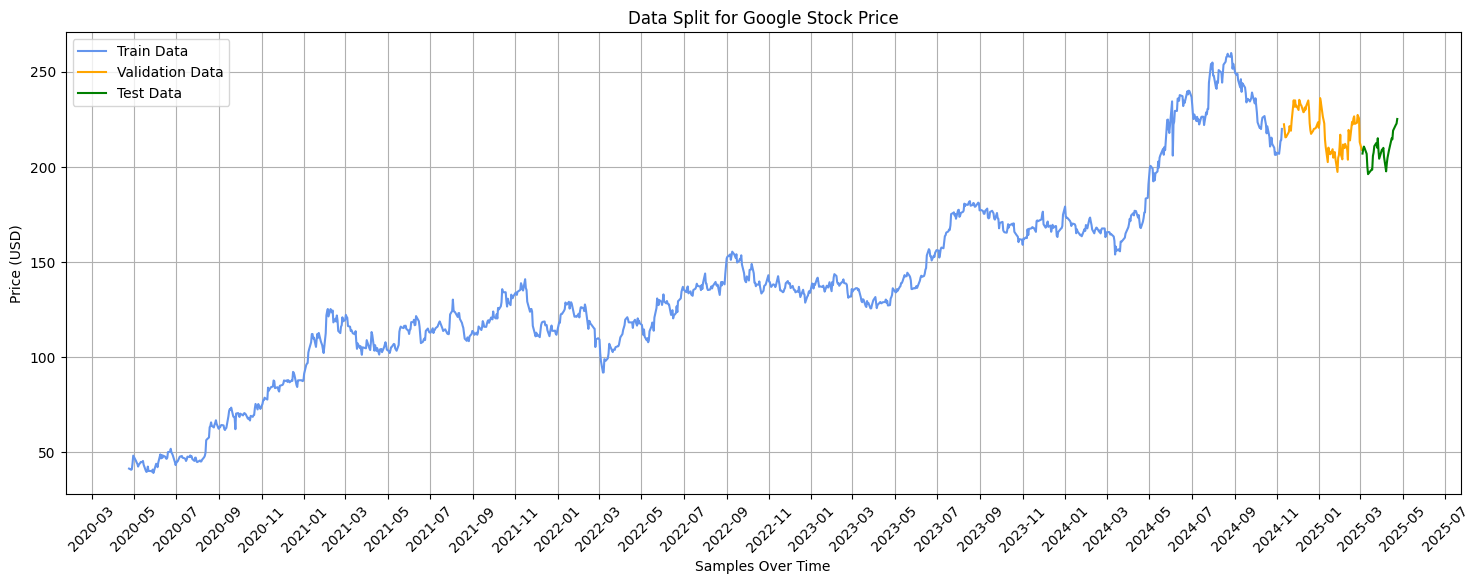

In [ ]:
# Plot stock prices for each data split
plt.figure(figsize=(18,6))

# Access Adj_Close from the original 'data' DataFrame using the date ranges
plt.plot(data_train_dates, data[data["Date"].isin(data_train_dates)]["Adj_Close"], color="cornflowerblue")
plt.plot(data_validate_dates, data[data["Date"].isin(data_validate_dates)]["Adj_Close"], color="orange")
plt.plot(data_test_dates, data[data["Date"].isin(data_test_dates)]["Adj_Close"], color="green")

plt.legend(["Train Data", "Validation Data", "Test Data"])
plt.title("Data Split for Google Stock Price")
plt.xlabel("Samples Over Time")
plt.ylabel("Price (USD)")
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=2))
plt.xticks(rotation=45)
plt.grid()

#### Data Scaling

In [ ]:
# Check the distribution of input features
data[features].describe()

,Date,Adj_Close,High,Low,Open,Volume,20MA,50MA,200MA,EMA,...,Price_to_MA_20,Price_to_MA_50,Price_to_MA_200,Trend_Strength,Global_Positive_Count,Global_Negative_Count,Global_Sentiment,Global_Lead,Global_Signal,MA_Combined_Signal
count,1238,1238.000000,1238.000000,1238.000000,1238.000000,1.238000e+03,1238.000000,1238.000000,1238.000000,1238.000000,...,1238.000000,1238.000000,1238.000000,1238.000000,1238.000000,1238.000000,1238.000000,1238.000000,1238.000000,1238.000000
mean,2022-10-18 21:57:52.051696128,142.752149,151.801930,147.402908,149.801163,1.872392e+07,141.443025,139.485538,131.676546,141.436357,...,0.011886,0.034690,0.214549,0.811793,1.596123,1.379645,0.216478,0.214055,0.088853,0.265549
min,2020-04-24 00:00:00,39.137318,43.549999,42.000000,43.049999,0.000000e+00,42.237420,44.753918,67.815664,41.355462,...,-0.196255,-0.227840,-0.229348,-2.000000,0.000000,0.000000,-3.000000,-3.000000,-1.000000,-1.000000
25%,2021-07-19 06:00:00,113.523178,125.012501,121.000000,123.337502,8.374284e+06,114.308410,112.433677,101.374418,113.918635,...,-0.021831,-0.022720,0.024279,0.000000,1.000000,0.000000,-1.000000,-1.000000,-1.000000,-0.250000
50%,2022-10-17 12:00:00,135.654846,147.449997,143.949997,145.875000,1.280264e+07,135.462910,133.913968,126.700534,135.522381,...,0.007439,0.027567,0.110374,1.000000,2.000000,1.000000,1.000000,1.000000,1.000000,0.250000
75%,2024-01-16 18:00:00,172.683674,180.075005,175.950001,178.000000,2.193438e+07,169.988290,169.131681,160.168487,170.003526,...,0.042685,0.076738,0.266686,2.000000,3.000000,2.000000,3.000000,3.000000,1.000000,0.750000
max,2025-04-23 00:00:00,259.769531,264.649994,260.000000,262.500000,2.450064e+08,252.880157,245.389698,227.034147,251.799797,...,0.297779,0.349561,0.835557,2.000000,3.000000,3.000000,3.000000,3.000000,1.000000,1.000000
std,NaN,51.456887,50.221841,49.312769,49.839831,1.890586e+07,51.551098,51.621329,45.712548,51.446092,...,0.053606,0.082865,0.284311,1.171318,1.097532,1.097350,2.186899,2.185473,0.991568,0.602399


Looking at these details, it's noticeable and anticipated that all price values exhibit similar distributions given they log the price fluctuation on daily basis.

Conversely, the trading volume presents a distinct distribution that differs significantly.

Accordingly, input features need to be transformed into a unified scale and since the distribution doesn't indicate any outliers, we will use the [0,1] range to normalize all features.

To prevent data leakage, we will fit the scaler solely to the training data. Subsequently, we will use this fitted scaler to transform the training, validation, and testing datasets.

In [ ]:
# Initialize scaler with range [0,1]
sc = MinMaxScaler(feature_range=(0,1))

# Columns to exclude from scaling
exclude_from_scaling = ['Date', 'Adj_Close']  # Add target variable

# Add other columns that don't need scaling
already_normalized = [
    'RSI_14', 'RSI_7', 'Stoch_RSI',  # Already 0-100 normalized
    'MA_20_50_Cross', 'MA_50_200_Cross', 'EMA_20_50_Cross', 'MA_Signal',  # Already -1 to 1
    'Day_of_Week', 'Month', 'Quarter'  # Categorical features
]

exclude_from_scaling.extend(already_normalized)

# Select only columns that need scaling
features_to_scale = [col for col in data_train.columns if col not in exclude_from_scaling]

# Create copies of the original dataframes to preserve original data
data_train_processed = data_train.copy()
data_validate_processed = data_validate.copy()
data_test_processed = data_test.copy()

# Scale only the selected features
scaled_train_features = sc.fit_transform(data_train[features_to_scale])
scaled_validate_features = sc.transform(data_validate[features_to_scale])
scaled_test_features = sc.transform(data_test[features_to_scale])

# Convert scaled arrays back to dataframes with column names
scaled_train_df = pd.DataFrame(scaled_train_features, columns=features_to_scale, index=data_train.index)
scaled_validate_df = pd.DataFrame(scaled_validate_features, columns=features_to_scale, index=data_validate.index)
scaled_test_df = pd.DataFrame(scaled_test_features, columns=features_to_scale, index=data_test.index)

# Replace only the scaled columns in the processed dataframes
for col in features_to_scale:
    data_train_processed[col] = scaled_train_df[col]
    data_validate_processed[col] = scaled_validate_df[col]
    data_test_processed[col] = scaled_test_df[col]

# Now data_train_processed, data_validate_processed, and data_test_processed contain
# all columns, with only the appropriate ones scaled

In [ ]:
data_train_processed.tail()

,Date,Adj_Close,High,Low,Open,Volume,20MA,50MA,200MA,EMA,...,Price_to_MA_20,Price_to_MA_50,Price_to_MA_200,Trend_Strength,Global_Positive_Count,Global_Negative_Count,Global_Sentiment,Global_Lead,Global_Signal,MA_Combined_Signal
1123,2024-11-04,206.814804,0.755993,0.733945,0.763955,0.042013,0.822986,0.928939,0.993650,0.826570,...,0.314830,0.212382,0.212480,0.5,0.000000,1.000000,0.000000,0.333333,0.0,0.250
1124,2024-11-05,209.916367,0.765943,0.756927,0.754796,0.018821,0.820485,0.924167,0.995067,0.824132,...,0.348776,0.242165,0.225608,0.5,0.666667,0.333333,0.666667,0.000000,0.0,0.375
1125,2024-11-06,213.652130,0.782225,0.779083,0.778309,0.021274,0.819025,0.919570,0.996615,0.823617,...,0.386817,0.276741,0.241490,0.5,1.000000,0.000000,1.000000,0.666667,1.0,0.375
1126,2024-11-07,213.939499,0.788105,0.787844,0.796309,0.027520,0.816719,0.915170,0.998186,0.823282,...,0.394095,0.285161,0.241763,0.5,0.666667,0.333333,0.666667,1.000000,1.0,0.375
1127,2024-11-08,219.875107,0.810267,0.773028,0.787651,0.081438,0.815315,0.912018,1.000000,0.825664,...,0.453037,0.334805,0.267335,0.5,1.000000,0.000000,1.000000,0.666667,1.0,0.375


The scaler employed here will also be utilized in subsequent phases to revert the scaled data back to its original distribution. Therefore, it is essential to save this scaler to a local folder for future use.

In [ ]:
import os

In [ ]:
# Prepare scaler model name and location
scaler_model_location = "/content/drive/MyDrive/Colab_Notebooks/models/"
scaler_model_name = "AshokLeyland_stock_price_scaler"
scaler_model_ext = "gz"

os.makedirs(scaler_model_location, exist_ok=True)
# Store scaler model
joblib.dump(sc, scaler_model_location + scaler_model_name + "." + scaler_model_ext)

['/content/drive/MyDrive/Colab_Notebooks/models/AshokLeyland_stock_price_scaler.gz']

### 4. STORING PROCESSED DATASETS

The training, validation, and testing datasets have been processed and are prepared for training the LSTM model in the next phase.

Prior to saving these datasets, it is necessary to reassemble the dates corresponding to each dataset. This will facilitate later evaluation of the model's performance.

In [ ]:
# Create the final scaled dataframes with ALL columns
data_train_scaled_final = data_train_processed.copy()
data_validate_scaled_final = data_validate_processed.copy()
data_test_scaled_final = data_test_processed.copy()

# If you need to separately store the dates and ensure they're properly set
data_train_scaled_final["Date"] = data_train_dates.values
data_validate_scaled_final["Date"] = data_validate_dates.values
data_test_scaled_final["Date"] = data_test_dates.values

In [ ]:
data_train_scaled_final.columns

Index(['Date', 'Adj_Close', 'High', 'Low', 'Open', 'Volume', '20MA', '50MA', '200MA', 'EMA', '50EMA', '200EMA', 'MACD',
       'MACD_Signal', 'MACD_Hist', 'BB_High', 'BB_Low', 'BB_Mid', 'BB_Width', 'Dist_From_Upper_Band',
       'Dist_From_Lower_Band', 'OBV', 'Volume_MA10', 'Volume_Ratio', 'RSI_14', 'RSI_7', 'Stoch_RSI', 'Williams_R',
       'ADX', 'DI_pos', 'DI_neg', 'Ichimoku_A', 'Ichimoku_B', 'Ichimoku_Base', 'Ichimoku_Conv', 'Daily_Return',
       'Log_Return', '5D_Return', '10D_Return', 'Close_Lag1', 'Close_Lag2', 'Close_Lag3', 'Close_Lag5', 'Day_of_Week',
       'Month', 'Day_of_Month', 'Quarter', 'Monthly_Volatility', 'MA_20_50_Cross', 'MA_50_200_Cross',
       'EMA_20_50_Cross', 'MA_Signal', 'Price_to_MA_20', 'Price_to_MA_50', 'Price_to_MA_200', 'Trend_Strength',
       'Global_Positive_Count', 'Global_Negative_Count', 'Global_Sentiment', 'Global_Lead', 'Global_Signal',
       'MA_Combined_Signal'],
      dtype='object')

In [ ]:
# # Combine dates with each corresponding dataset
# data_train_scaled_final = pd.DataFrame(data_train_scaled, columns=features, index=None)
# data_train_scaled_final["Date"] = data_train_dates.values

# data_validate_scaled_final = pd.DataFrame(data_validate_scaled, columns=features, index=None)
# data_validate_scaled_final["Date"] = data_validate_dates.values

# data_test_scaled_final = pd.DataFrame(data_test_scaled, columns=features, index=None)
# data_test_scaled_final["Date"] = data_test_dates.values

In [ ]:
# Prepare datasets files and location
data_file_location = "/content/drive/MyDrive/Colab_Notebooks/processed/"
data_file_name_train = "AshokLeyland_stock_price_processed_train"
data_file_name_validate = "AshokLeyland_stock_price_processed_validate"
data_file_name_test = "AshokLeyLand_stock_price_processed_test"
data_file_ext = "csv"

# Create the directory if it doesn't exist
os.makedirs(data_file_location, exist_ok=True)
# Store datasets
data_train_scaled_final.to_csv(data_file_location + data_file_name_train + "." + data_file_ext, index=None)
data_validate_scaled_final.to_csv(data_file_location + data_file_name_validate + "." + data_file_ext, index=None)
data_test_scaled_final.to_csv(data_file_location + data_file_name_test + "." + data_file_ext, index=None)